## INDVAL based feature selection and Keras modeling

In [158]:
running_on_ubuntu2204 = True
running_on_macos = False
running_on_colab = False #not published. Please contact authors for a Google colab version
dataset_root = '/home/ashiskb/Documents/data/NPDS-data/'

### (AshisKB) Imports & workspace configuration

In [159]:
#!pip install --upgrade pip
#!pip install -U jupyterlab ipywidgets
#!pip3 install tensorflow
#!pip install tqdm
#!pip3 install -U scikit-learn
#!pip install xgboost
#!pip install lightgbm
#!pip install imblearn
#!pip install pyreadstat
#!pip install matplotlib pandas numpy
#!pip install seaborn


In [160]:
#!pip freeze > requirements_ubuntu2204_Keras.txt
#!pip install -r requirements_macos.txt
#!pip freeze > requirements_ubuntu2204.txt

In [161]:
if running_on_ubuntu2204:
    #checking cuda version and cuda support
    !nvidia-smi

Thu Feb  9 16:02:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P2    39W /  N/A |   7851MiB /  8192MiB |     59%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [162]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Input
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as AdaBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier as XGBC
from lightgbm import LGBMClassifier as LGBC

from imblearn.over_sampling import SMOTE, RandomOverSampler

from scipy.special import softmax
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors
import time
import joblib
from tqdm import tqdm
import seaborn as sns
import copy

    


### (AshisKB) Utility functions

In [163]:
# result: score matrix
# confus: confusion matrix
# setname: data set name (train or test or validation)
# modelname: name of the prediction model
# savedir: directory path where the graph will be saved
def plot_tables(result, confus, setname, modelname, savedir):
    fig, ax = plt.subplots(figsize = (22, 5), ncols = 2)
    ax[0] = msd.plot_heatmap(result, annotate = True, fmt = '.3f', xrot = 0, vmax = 1, axobj = ax[0], cmap = 'summer', fig_title = 'Score Matrix')
    ax[1] = msd.plot_heatmap(confus, annotate = True, fmt = 'd', xrot = 0, axobj = ax[1], cmap = 'Blues', fig_title = 'Confusion Matrix')
    fig.suptitle('Classification result for %s from %s'%(setname, modelname), fontsize = 15, fontweight = 'bold')
    fig.tight_layout()
    fig.savefig('%s/Classification result for %s from %s.png'%(savedir, setname, modelname), bbox_inches = 'tight')
    plt.show()
    plt.close()

In [164]:
def get_weighted_scores(score, y_test):
    _score = score.copy()
    counts = pd.Series(y_test).value_counts().sort_index().to_frame().T
    _score['weighted_average'] = (_score.drop('accuracy').drop('average', axis=1).values * counts.values / counts.values.sum()).sum(axis=1).tolist()+[_score['average'].loc['accuracy']]
    return _score

In [165]:
"""
input_units: int, number of units in input layer / number of features (not first hidden layer)
output_units: int, number of units in output layer / number of output nodes / number of classes (not last hidden layer)
unit_factors: array of ints or floats, multipliers to calculate number of units in each hidden layer from input_units, or actual number of units for each hidden layer
dropout_rate: dropout ratio
model_type: {'classification', 'regression'}, controls use of softmax on top of output layer
actual_units: bool, whether actual units are placed in unit_factors or not
"""
def define_layers(input_units, output_units, unit_factors, dropout_rate, model_type, actual_units=False):
    if actual_units:
        hidden_units = unit_factors.copy()
    else:
        hidden_units = [input_units * factor for factor in unit_factors]
    units = [input_units] + hidden_units + [output_units]
    units = [int(i) for i in units]
    
    layers = []
    for i in range(len(unit_factors)):
        layers.append(nn.Linear(units[i], units[i + 1]))
        layers.append(nn.Sigmoid())
        layers.append(nn.BatchNorm1d(units[i + 1]))
        layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(units[-2], units[-1]))
    if model_type == 'classifier':
        layers.append(nn.Softmax(dim=1))
    return layers

In [166]:
# storing the models and loading them
def store_models(models, folder_path):
    if not os.path.exists(folder_path): os.makedirs(folder_path)
    for modelname in models:
        print('storing models... %s_model...'%modelname, end='')
        if 'pytorch' in modelname.lower():
            torch.save(models[modelname].model.state_dict(), folder_path + '/%s_model.pt'%modelname)
        else:
            with open(folder_path + '/%s_model.pickle'%modelname, 'wb') as f:
                joblib.dump(models[modelname], f)
        print('   ...storing completed !!')
    
def load_models(models, folder_path):
    for modelname in models:
        print('\rloading models... %s_model...'%modelname, end='')
        if 'pytorch' in modelname.lower():
            models[modelname].model.load_state_dict(torch.load(folder_path + '/%s_model.pt'%modelname))
        else:
            with open(folder_path + '%s_model.pickle'%modelname, 'rb') as f:
                models[modelname] = joblib.load(f)
        print('   ...loading completed !!')
    return models

In [167]:
"""
n_layers: number of hidden layers
offset_factor: makes assymetric structure (base - offset)
max_factor: multiplier for mid layer (largest layer)
base_factor: multiplier for first layer
"""
def get_factors(n_layers, base_factor=5, max_factor=10, offset_factor=2):
    base_factor = max_factor - base_factor
    return [max_factor - abs(x) for x in np.linspace(-base_factor, base_factor + offset_factor, n_layers) if max_factor - abs(x) > 0]

In [168]:
def prepare_row(age, product, outcome, therapy, effects, zeros, val2index, columns):
    # adding the data to stack
    _zeros = {key: zeros[key].copy() for key in zeros}
    # stacking clinical effect
    for k in effects: _zeros['Clinical_Effect'][val2index['Clinical_Effect'][k]] = 1
    for k in therapy: _zeros['Therapy'][val2index['Therapy'][k]] = 1
    # stacking medical outcome
    _zeros['Medical_Outcome'][val2index['Medical_Outcome'][outcome]] = 1
    # combining
    row = np.concatenate([[age]] + [_zeros[col] for col in columns] + [[product]], axis=0)
    return row

In [169]:
def prepare_data(_rawdata, ):
    
    rawdata = _rawdata.copy()
    # filling nan values
    for c in rawdata.columns:
        rawdata[c] = rawdata[c].fillna('NAN').replace(' ', '').replace('', 'NAN')
    
    # extrcting data from rows
    columns = ['Clinical_Effect', 'Therapy', 'Medical_Outcome']
    val2index = {col: {k: i for i, k in enumerate(np.sort(rawdata[col].unique()))} for col in columns}
    zeros = {col: np.zeros(rawdata[col].unique().shape[0]) for col in columns}

    # initializing counts
    product = rawdata['Product'].iloc[0]
    age = rawdata['Age'].iloc[0]
    effects = [rawdata['Clinical_Effect'].iloc[0]]
    outcome = rawdata['Medical_Outcome'].iloc[0]
    therapy = [rawdata['Therapy'].iloc[0]]
    root_index = [0]
    data_stack = []
    for i in tqdm(range(1, rawdata.shape[0])):
        if rawdata['Product'].iloc[i] != 'NAN':
            row = prepare_row(age, product, outcome, therapy, effects, zeros, val2index, columns)
            data_stack.append(row)
            # initializing again
            product = rawdata['Product'].iloc[i]
            age = rawdata['Age'].iloc[i]
            effects = [rawdata['Clinical_Effect'].iloc[i]]
            outcome = rawdata['Medical_Outcome'].iloc[i]
            therapy = [rawdata['Therapy'].iloc[i]]
            root_index.append(i)
        else:
            # appending effects
            effects.append(rawdata['Clinical_Effect'].iloc[i])
            therapy.append(rawdata['Therapy'].iloc[i])
    row = prepare_row(age, product, outcome, therapy, effects, zeros, val2index, columns)
    data_stack.append(row)
    
    cols = ['%s: %s'%(col, k) for col in columns for k in pd.Series(val2index[col]).to_frame(col).reset_index(drop=False).set_index(col).sort_index()['index'].to_list()]
    return pd.DataFrame(np.array(data_stack), columns=['Age'] + cols + ['Product']), root_index

### (AshisKB) Read the conglomerated dataset

In [202]:
df=pd.read_spss(dataset_root+"good.sav")

In [203]:
df.head()

,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,Asystole,...,Xrayfindings,Age,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,product,gender__Male
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,69.0,1.0,0.0,0.0,0.0,0.0,1.0,Benzodiazepines,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,1.0,0.0,0.0,0.0,0.0,1.0,Diphenhydramine,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,17.0,1.0,0.0,0.0,0.0,1.0,0.0,Diphenhydramine,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,1.0,0.0,0.0,0.0,0.0,1.0,Diphenhydramine,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,Bupropion,0.0


In [204]:
df.to_csv(dataset_root+'good.csv',index=False)

In [173]:
#shape of the dataset
print(f'Num of samples = {df.shape[0]}, \nnum of variables = {df.shape[1]}')

Num of samples = 206027, 
num of variables = 134


In [174]:
#list all column names~
print(f'List of {df.shape[1]} variable names = {list(df.columns)}')

List of 134 variable names = ['ADRtotreatment', 'ASTALTgt1000', 'ASTALTgt100lt1000', 'AbdominalPain', 'Acidosis', 'Agitation', 'Alkalosis', 'Aniongapincreased', 'Anorexia', 'Asystole', 'Ataxia', 'Bilirubinincreased', 'Bleedingother', 'BlistersBullae', 'Bloodperrectumother', 'Blurredvision', 'Bradycardia', 'Bronchospasm', 'Burns', 'Burnssuperficial', 'Burns23degree', 'CPKelevated', 'CVA', 'Cardiacarrest', 'Cellulitis', 'Chestpaininclnoncardiac', 'Coagulopathyother', 'Coma', 'Conductiondisturbance', 'Confusion', 'Constipation', 'Cornealabrasion', 'Creatinineincreased', 'Cyanosis', 'Cytopenia', 'DIC', 'Deafness', 'Dehydration', 'DermalIrritationpain', 'Diaphoresis', 'Diarrhea', 'Dizzinessvertigo', 'Drowsinesslethargy', 'Dysphagia', 'Dyspnea', 'DysrhythmiaotherNOS', 'ECGchangeotherNOS', 'EPSdystonia', 'Ecchymosis', 'Edema', 'Electrolyteabnormality', 'Erythemaflushed', 'Esophagealinjury', 'Esophagealstricture', 'Excesssecretions', 'Fasciculations', 'Fecalincontinence', 'Fetaldeath', 'Feverh

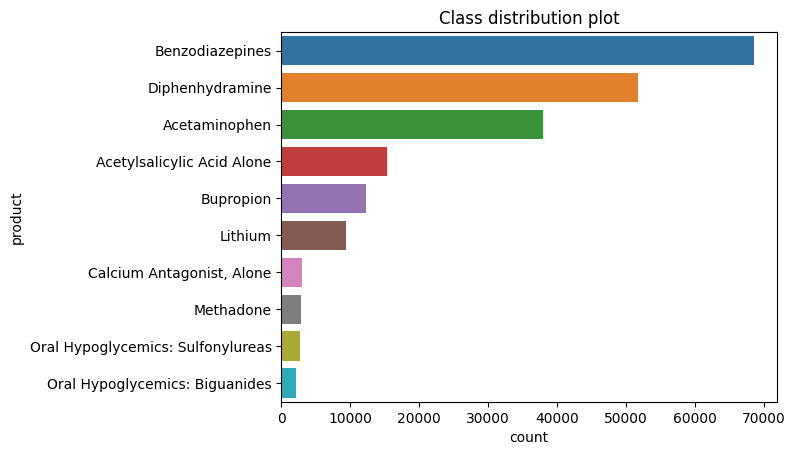

In [175]:
#target variable/column = 'product'

sns.countplot(y = 'product', data=df, order=df['product'].value_counts().index).set(title='Class distribution plot')
plt.savefig('figures/class_distribution_before_del_classes.svg')

In [176]:
df['product'].value_counts()

Benzodiazepines                      68536
Diphenhydramine                      51798
Acetaminophen                        38033
Acetylsalicylic Acid Alone           15268
Bupropion                            12328
Lithium                               9434
Calcium Antagonist, Alone             2945
Methadone                             2791
Oral Hypoglycemics: Sulfonylureas     2689
Oral Hypoglycemics: Biguanides        2205
Name: product, dtype: int64

In [177]:
# removing products to reduce number of target class
del_classes = ['Methadone', 'Oral Hypoglycemics: Biguanides','Bupropion','Calcium Antagonist, Alone']
del_columns = ['Age'] #deleting non binary features for the INDVAL study
# del_classes = []

df_minus5 = df.set_index('product').loc[[i for i in df['product'].unique() if i not in del_classes]].reset_index(drop=False)
df_minus5.drop(del_columns, axis=1,inplace=True)


In [178]:
df_minus5.head()

,product,ADRtotreatment,ASTALTgt1000,ASTALTgt100lt1000,AbdominalPain,Acidosis,Agitation,Alkalosis,Aniongapincreased,Anorexia,...,Visualdefect,Vomiting,Xrayfindings,reason__Intentional,reason__Other,reason__Unintentional,Medical_Outcome__Majoreffect,Medical_Outcome__Minoreffect,Medical_Outcome__Moderateeffect,gender__Male
0,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,Benzodiazepines,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [179]:
#shape of the dataset
print(f'Num of samples = {df_minus5.shape[0]}, \nnum of variables = {df_minus5.shape[1]}')

Num of samples = 185758, 
num of variables = 133


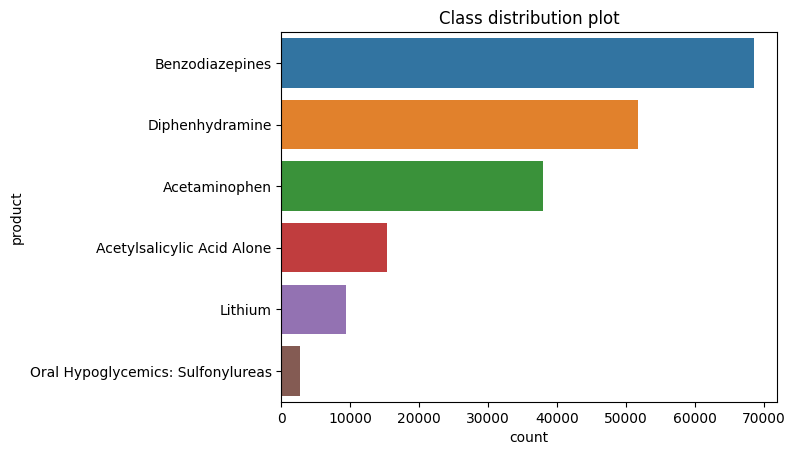

In [180]:
#target variable/column = 'product'

sns.countplot(y = 'product', data=df_minus5, order=df_minus5['product'].value_counts().index).set(title='Class distribution plot')
plt.savefig('figures/class_distribution_after_del_classes.svg')

In [181]:
df_minus5['product'].value_counts()

Benzodiazepines                      68536
Diphenhydramine                      51798
Acetaminophen                        38033
Acetylsalicylic Acid Alone           15268
Lithium                               9434
Oral Hypoglycemics: Sulfonylureas     2689
Name: product, dtype: int64

In [182]:
#display(HTML("<style>.container { width:100% !important; }</style>"))
#pd.set_option('display.max_columns', None)

In [183]:
#rawdata = pd.read_spss('final.csv.for abdullah.sav').replace('', np.nan).drop('productnew', axis=1)
#rawdata['Medical_Outcome'].iloc[0] = 'Minor effect'
#rawdata['Therapy'].iloc[0] = 'Fluids, IV'
#rawdata

In [184]:
# total products found
#rawdata['Product'].dropna().shape

In [185]:
### Process data to create one hot table for categorical features
#newdata, raw_index = prepare_data(rawdata)
#for c in newdata.columns:
#    if c == 'Age': newdata[c] = newdata[c].values.astype(float)
#    elif c == 'Product': pass
#    else: newdata[c] = newdata[c].values.astype(float).astype(int)
#
#newdata.to_pickle('raw_to_processed_data.pickle')

### (AshisKB) Prepare training data set 'data'

In [186]:

#### Verification of data set organizing process# i = 10100
# idx1, idx2 = rawdata['Product'].dropna().index[i], rawdata['Product'].dropna().index[i+1]
# idx1, idx2

In [187]:
# rawdata.iloc[idx1: idx2+1]

In [188]:
# newdata.iloc[i][newdata.iloc[i].astype(bool)].to_frame().T

In [189]:
# # selecting only clinical effect features
# effect_cols = [c for c in newdata.columns if 'Clinical_Effect:' in c]
# data = pd.DataFrame(newdata[effect_cols].copy())
# data.columns = [k.replace('Clinical_Effect: ', '') for k in data.columns]
# data['product'] = newdata['product'].copy()
# data

In [190]:
# available products
#data['product'].unique()

In [191]:
# removing products to reduce number of target class
#del_classes = ['Methadone', 'Oral Hypoglycemics: Biguanides','Bupropion','Calcium Antagonist, Alone']
# del_classes = []

#data = data.set_index('product').loc[[i for i in data['product'].unique() if i not in del_classes]].reset_index(drop=False)





In [192]:
#data.head()

In [193]:
# checking nan values if any
print(df_minus5.info())
df_minus5.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185758 entries, 0 to 185757
Columns: 133 entries, product to gender__Male
dtypes: float64(132), object(1)
memory usage: 188.5+ MB
None


0

In [194]:
#df_minus4.nunique().unique()

In [195]:
# checking number of labels in each class
#data['product'].value_counts()

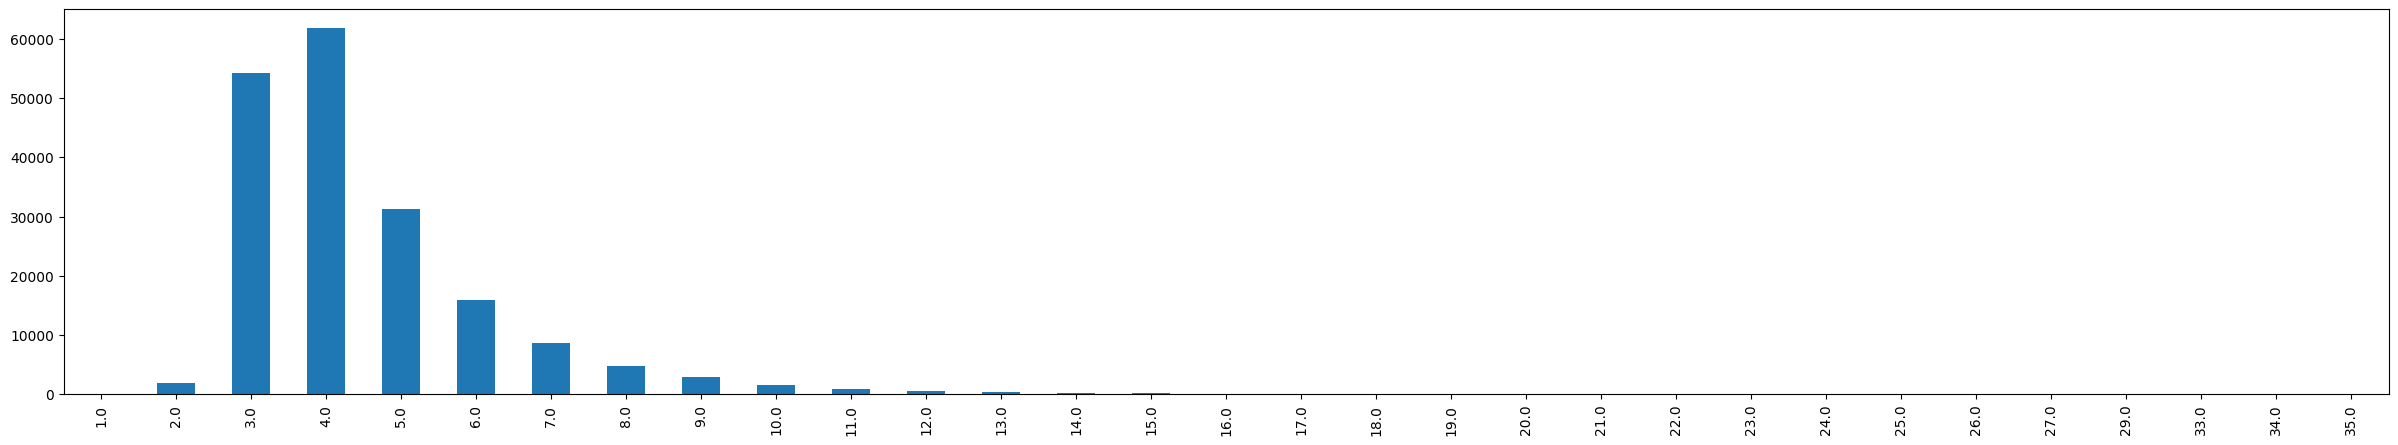

In [196]:
# # sample count (y-axis) for various number of clinical features (x axis)
rowsum = df_minus5.drop('product', axis=1).sum(axis=1)
rowsum.value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.show()

In [197]:
rowsum.value_counts()

4.0     61850
3.0     54184
5.0     31253
6.0     15872
7.0      8646
8.0      4865
9.0      2879
2.0      1911
10.0     1639
11.0      976
12.0      562
13.0      379
14.0      221
15.0      162
16.0      102
17.0       65
18.0       42
19.0       32
1.0        30
20.0       27
21.0       18
23.0       14
22.0       11
24.0        5
26.0        4
27.0        3
29.0        2
25.0        1
35.0        1
33.0        1
34.0        1
dtype: int64

In [198]:
# # checking samples where only one clinical feature is present
num = 1
numdata = df_minus5.loc[rowsum[rowsum == num].index].drop('product', axis=1)
idx = np.where(numdata.astype(bool))
idx

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 42, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
        129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 129,
        129, 129, 129, 129]))

In [199]:
# # real index from 'data'
numdata.index

Int64Index([ 24875,  72717,  73101,  75324,  76118,  82231,  82688,  94111,
             96553, 100450, 102003, 102899, 110776, 134710, 137540, 138378,
            140732, 156294, 173933, 174593, 175153, 175852, 176545, 177375,
            177847, 177871, 178542, 179192, 180642, 180791],
           dtype='int64')

In [200]:
#### remove all indices/data where only one clinical effect is presentd
df_minus5.drop(numdata.index, axis=0, inplace=True)
df_minus5.shape

(185728, 133)

In [201]:
df_minus5.to_csv(dataset_root+'df_minus5.csv',index=False)

In [44]:
#### Remove only ambiguous indices where one clinical effect is present for minority classes

#counts = []
#columns = df_minus4.drop('product', axis=1).columns
#for i in np.sort(np.unique(idx[1])):
#    counts.append(df_minus4.loc[numdata.index[np.where(idx[1] == i)[0]]]['product'].value_counts().rename(columns[i]))
#counts = pd.concat(counts, axis=1, sort=False)
#counts.index = counts.index.to_list()
#counts = pd.concat([counts, counts.sum().to_frame('sum').T, (counts.sum() - counts.max()).to_frame('# minority class instance').T], axis=0, sort=False)
#counts

In [45]:
## # collecting invalid indices based on minority classes
#invalid_indices = []
#
#for feature in counts.columns:
#    indices = numdata.index[idx[0][np.where(idx[1] == np.where(columns == feature)[0][0])[0]]].to_list()
#    dom_feat = counts[feature].iloc[:-2].idxmax()
#    rem_idx = data.loc[indices].reset_index(drop=False).set_index('product').drop(dom_feat, axis=0)['index'].to_list()
#    invalid_indices += rem_idx
#invalid_indices = sorted(invalid_indices)

## # removing samples that are invalid
#data.drop(invalid_indices, axis=0, inplace=True)

In [46]:
### Additional data visualization

# ratios = pd.Series(data.set_index('product').sum()/data.shape[0], name='ratio_1').to_frame()
# ratios['ratio_0'] = 1 - ratios['ratio_1']
# ratios.plot(kind='bar', figsize=(35, 6), title='ratio of 1 and 0 for all features', stacked=True)
# plt.show()

In [47]:
# # ratio of 1 in different classes
# feature_ratios = []
# _data = data.set_index('product')
# for c in data.columns.drop('product'):
#     print(c)
#     temp = _data[c][_data[c].astype(bool)]
#     feature_ratios.append((temp.index.value_counts() / temp.shape[0]).rename(c))
# feature_ratios = pd.concat(feature_ratios, axis=1, sort=False)
# msd.plot_heatmap(feature_ratios, figsize=(40, 9))

In [48]:
# feature_ratios.T.plot.barh(figsize=(10, 40), stacked=True)
# plt.show()

In [49]:
# onlydata = data.drop('product', axis=1).copy()
# label = data['product'].copy()

In [50]:
# thres = .5

# featsum = onlydata.sum()
# sel_features = []
# for _class in label.unique():
#     idx = label == _class
#     featratio = (onlydata[idx].sum() / featsum).to_frame('feature_coverage')
#     featratio['class_coverage'] = onlydata[idx].sum() / idx.sum()
#     sel_features += featratio['feature_coverage'][featratio['feature_coverage'] >= thres].index.to_list()
#     featratio.plot.bar(figsize=(30, 6), title='%s feature distribution'%_class)
#     plt.show()
# sel_features

In [51]:
# onlydata[sel_features].shape

In [52]:
# label names to index mapping and reverse mapping
label2index = {k: i for i, k in enumerate(np.sort(df_minus5['product'].unique()))}
index2label = {label2index[k]: k for k in label2index}
print(f'label2index = {label2index}')
print(f'index2label = {index2label}')

label2index = {'Acetaminophen': 0, 'Acetylsalicylic Acid Alone': 1, 'Benzodiazepines': 2, 'Diphenhydramine': 3, 'Lithium': 4, 'Oral Hypoglycemics: Sulfonylureas': 5}
index2label = {0: 'Acetaminophen', 1: 'Acetylsalicylic Acid Alone', 2: 'Benzodiazepines', 3: 'Diphenhydramine', 4: 'Lithium', 5: 'Oral Hypoglycemics: Sulfonylureas'}


In [53]:
### Statistical feature importance (isnt used though in later stages)
# feature importance analysis
df_minus5_labeled = df_minus5.copy(deep=True)
df_minus5_labeled['product'] = df_minus5['product'].replace(label2index)


In [214]:
#preparing dataframe for indval analysis in R
df_npds_data = df_minus5.copy()
#Need to remove the features which do not occur in any sample
for feature in df_npds_data.columns:
    if np.sum(df_npds_data[feature])==0:
        print(f'>>> removing non-occuring feature {feature}')
        df_npds_data.drop([feature],axis=1,inplace=True)




>>> removing non-occuring feature Gastricburns
>>> removing non-occuring feature Necrosis


In [216]:
len(df_npds_data.columns), len(df_minus5.columns)

(131, 133)

In [218]:
df_npds_groups = pd.DataFrame(df_minus5['product'],columns=['product'])
df_npds_groups['group'] = df_minus5['product'].replace(label2index)
df_npds_data.to_csv(dataset_root+'indval-workspace/df_npds_data.csv',index=False)
df_npds_groups.to_csv(dataset_root+'indval-workspace/df_npds_groups.csv',index=False)

### (AshisKB) INDVAL based feature selection (R version)
* Make sure you run ``indVal-ashiskb-2-npds-data.R`` on the saved csv files from the previous cell.
* Output is basically the ``indvalsummary-npds-on-131-features.csv`` summary csv,
    - First column lists the top-99 features based on indval analysis

In [243]:
indval_summary = pd.read_csv(dataset_root+'indval-workspace/indvalsummary-npds-on-131-features.csv')


In [319]:
#including all features
#the_columns = list(df_npds_data.columns)
#the_columns.remove('product')

In [321]:
#Now, feature selection using INDVAL
num_of_features_to_keep = 85
features_to_keep =  indval_summary.iloc[:,0][:num_of_features_to_keep]
print(len(features_to_keep))



85


In [322]:
# separating label (product) column from the rest of data
y = df_minus5_labeled['product'].copy()
X = df_minus5_labeled.drop(['product'], axis=1)


In [323]:
#X_idv is the feature selected data
X_idv = X.loc[:,features_to_keep]
X_idv.shape

(185728, 85)

In [324]:
#Three-way split ratio
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15


In [325]:

#SMOTE = Synthetic Minority Oversampling Technique (SMOTE)
#X_resampled, y_resampled = SMOTE().fit_resample(X2,y)
X_resampled,y_resampled = X_idv, y
print(f'X_resampled.shape = {X_resampled.shape},\ny_resampled.shape = {y_resampled.shape}')
#class distribution after SMOTE()
#y_resampled.value_counts()
#first split two-way and separate out the test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_ratio, random_state=12345)
#Convert dataframes into numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
print(f'X_train.shape = {X_train.shape},\nX_test.shape = {X_test.shape}')

X_resampled.shape = (185728, 85),
y_resampled.shape = (185728,)
X_train.shape = (157868, 85),
X_test.shape = (27860, 85)


* (AshisKB) Keras model parameters

In [326]:
# Deep NN model parameters
n_layers = 4
unit_factors = np.array(get_factors(n_layers=n_layers),dtype=int)
dropout_rate = .15
print(f'n_layers = {n_layers},\nunit_factors = {unit_factors}')

input_dim = X_train[0].shape[0]
output_dim = len(index2label)
print(f'input_dim = {input_dim}, output_dim = {output_dim}')
hidden_units = [input_dim * factor for factor in unit_factors]
units = [input_dim] + hidden_units + [output_dim]
units = [i for i in units]
print(f'units = {units}')

n_layers = 4,
unit_factors = [5 9 7 3]
input_dim = 85, output_dim = 6
units = [85, 425, 765, 595, 255, 6]


In [327]:
#Define Keras model
model = Sequential()
model.add(Dense(665, input_shape=(len(features_to_keep),), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(1197, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))


model.add(Dense(931, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))


model.add(Dense(399,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(6, activation='softmax'))


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 665)               57190     
                                                                 
 batch_normalization_36 (Bat  (None, 665)              2660      
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 665)               0         
                                                                 
 dense_46 (Dense)            (None, 1197)              797202    
                                                                 
 batch_normalization_37 (Bat  (None, 1197)             4788      
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 1197)             

In [328]:
#defining the hyper-parameters
learning_rate = 1e-3
batch_size = 64
epoch = 10
#f you want to use "categorical_crossentropy", the labels should be one-hot-encoded. In our case, it was not.
# When your labels are given as an integer, changing to "sparse_categorical_crossentropy" is required. 
# The advantage of using "categorical_crossentropy" is that it can give you class probabilities, which might be useful in some cases.
loss_function = "sparse_categorical_crossentropy"

#define optimizer 
#opt = optim.SGD(model.parameters(), lr=0.2,momentum=0.9)
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
#compile Keras model with the parameter settings
model.compile(loss=loss_function,optimizer=opt,metrics=["accuracy"])

In [329]:
#Let's train
#calculate time of training
tic = time.time()
log_tr = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size)
toc = time.time()
print('Time taken', toc - tic)


Epoch 1/10
2467/2467 [==============================] - 16s 5ms/step - loss: 0.5646 - accuracy: 0.7967
Epoch 2/10
2467/2467 [==============================] - 13s 5ms/step - loss: 0.5153 - accuracy: 0.8088
Epoch 3/10
2467/2467 [==============================] - 13s 5ms/step - loss: 0.5054 - accuracy: 0.8108
Epoch 4/10
2467/2467 [==============================] - 13s 5ms/step - loss: 0.4965 - accuracy: 0.8133
Epoch 5/10
2467/2467 [==============================] - 13s 5ms/step - loss: 0.4904 - accuracy: 0.8148
Epoch 6/10
2467/2467 [==============================] - 12s 5ms/step - loss: 0.4840 - accuracy: 0.8177
Epoch 7/10
2467/2467 [==============================] - 14s 6ms/step - loss: 0.4809 - accuracy: 0.8189
Epoch 8/10
2467/2467 [==============================] - 13s 5ms/step - loss: 0.4760 - accuracy: 0.8200
Epoch 9/10
2467/2467 [==============================] - 13s 5ms/step - loss: 0.4725 - accuracy: 0.8213
Epoch 10/10
2467/2467 [==============================] - 13s 5ms/step - l

In [330]:
##Save model (in Tensorflow SaveModel format (tf2))
model.save(f'./temp/20230209_2143_Keras_FFN_tf_INDVAL_R_features_selected={num_of_features_to_keep}')

INFO:tensorflow:Assets written to: ./temp/20230209_2143_Keras_FFN_tf_INDVAL_R_features_selected=85/assets


In [331]:
# evaluate the network
pred_probs = model.predict(X_test, batch_size=128)
predictions = [x.argmax() for x in pred_probs]
report = classification_report(y_test, predictions, target_names=[index2label[i]+'{'+str(i)+'}' for i in np.unique(y_train)])
print(report)
with open(f'{dataset_root}/temp/report_20230209_Keras_INDVAL_R_features_selected={num_of_features_to_keep}.txt','w') as f:
    f.write(report)

218/218 [==============================] - 0s 2ms/step
                                      precision    recall  f1-score   support

                    Acetaminophen{0}       0.86      0.91      0.89      5737
       Acetylsalicylic Acid Alone{1}       0.86      0.62      0.72      2234
                  Benzodiazepines{2}       0.83      0.84      0.83     10216
                  Diphenhydramine{3}       0.75      0.80      0.77      7803
                          Lithium{4}       0.85      0.65      0.73      1451
Oral Hypoglycemics: Sulfonylureas{5}       0.95      0.89      0.92       419

                            accuracy                           0.82     27860
                           macro avg       0.85      0.78      0.81     27860
                        weighted avg       0.82      0.82      0.82     27860



In [ ]:
#the end

In [342]:
#Draw plot of indval analysis
num_features_selected = [3, 5, 10, 25, 50, 85, 99, 130]
list_of_accuracy = []
list_of_precision = []
list_of_recall = []
list_of_f1 = []
for num in num_features_selected:
    classification_report_file = f'{dataset_root}/temp/report_20230209_Keras_INDVAL_R_features_selected={num}.txt'
    print(f'{classification_report_file}')
    with open(classification_report_file,'r') as f:
        lines = f.readlines()
        #read the 10th line for accuracy
        accuracy_line = lines[9]
        splits = accuracy_line.split()
        accuracy_l = []
        for sp in splits:
            #print(f'{sp},')
            accuracy_l.append(sp)
        if accuracy_l[0]=='accuracy':
            list_of_accuracy.append(float(accuracy_l[1]))
        else:
            print('Error! accuracy not reported!')
            
        #read the 12th line for weighted average of precision, recall, f1-score
        prf_line = lines[11]
        splits = prf_line.split()
        prf_l = []
        for sp in splits:
            #print(f'{sp},')
            prf_l.append(sp)
        if prf_l[0]=='weighted' and prf_l[1]=='avg':
            list_of_precision.append(float(prf_l[2]))
            list_of_recall.append(float(prf_l[3]))
            list_of_f1.append(float(prf_l[4]))
        else:
            print('Error! weighted avg not reported!')

    print(f'list of accuracy = {list_of_accuracy}')
    print(f'list of precision = {list_of_precision}')
    print(f'list of recall = {list_of_recall}')
    print(f'list of f1 = {list_of_f1}')

    
    #break

temp/report_20230209_Keras_INDVAL_R_features_selected=3.txt
list of accuracy = [0.55]
list of precision = [0.41]
list of recall = [0.55]
list of f1 = [0.45]
temp/report_20230209_Keras_INDVAL_R_features_selected=5.txt
list of accuracy = [0.55, 0.57]
list of precision = [0.41, 0.45]
list of recall = [0.55, 0.57]
list of f1 = [0.45, 0.48]
temp/report_20230209_Keras_INDVAL_R_features_selected=10.txt
list of accuracy = [0.55, 0.57, 0.71]
list of precision = [0.41, 0.45, 0.73]
list of recall = [0.55, 0.57, 0.71]
list of f1 = [0.45, 0.48, 0.7]
temp/report_20230209_Keras_INDVAL_R_features_selected=25.txt
list of accuracy = [0.55, 0.57, 0.71, 0.78]
list of precision = [0.41, 0.45, 0.73, 0.78]
list of recall = [0.55, 0.57, 0.71, 0.78]
list of f1 = [0.45, 0.48, 0.7, 0.77]
temp/report_20230209_Keras_INDVAL_R_features_selected=50.txt
list of accuracy = [0.55, 0.57, 0.71, 0.78, 0.81]
list of precision = [0.41, 0.45, 0.73, 0.78, 0.82]
list of recall = [0.55, 0.57, 0.71, 0.78, 0.81]
list of f1 = [0.45

In [351]:
plot_df = pd.DataFrame(list(zip(num_features_selected, list_of_accuracy, list_of_precision, list_of_recall, list_of_f1)), \
                        columns=['Num_Features_Selected', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [352]:
plot_df

,Num_Features_Selected,Accuracy,Precision,Recall,F1
0,3,0.55,0.41,0.55,0.45
1,5,0.57,0.45,0.57,0.48
2,10,0.71,0.73,0.71,0.70
3,25,0.78,0.78,0.78,0.77
4,50,0.81,0.82,0.81,0.81
5,85,0.82,0.82,0.82,0.82
6,99,0.82,0.82,0.82,0.82
7,130,0.82,0.82,0.82,0.82


<AxesSubplot: xlabel='Num_Features_Selected'>

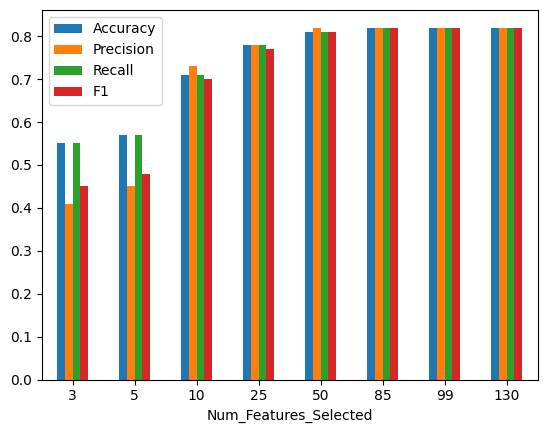

In [355]:
plot_df.plot(x='Num_Features_Selected', y=['Accuracy','Precision', 'Recall', 'F1'], kind='bar', rot=0)